In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

%matplotlib notebook

# Eigenfaces

Principal Component Analysis captures the variance of a set of data in a very convenient form. In this notebook, you will implement Eigenfaces: a facial recognition framework based on PCA. The idea is that the most important variances will be represented by the eigenvectors of the covariance matrix of faces.

In [2]:
# Load raw images
data_dir = "/home/alex/Downloads/ATTfaces/faces/"
file_names = os.listdir(data_dir)
images = [np.asarray(Image.open(data_dir + file_names[i])) for i in range(len(file_names))]
images = np.array(images)

<IPython.core.display.Javascript object>


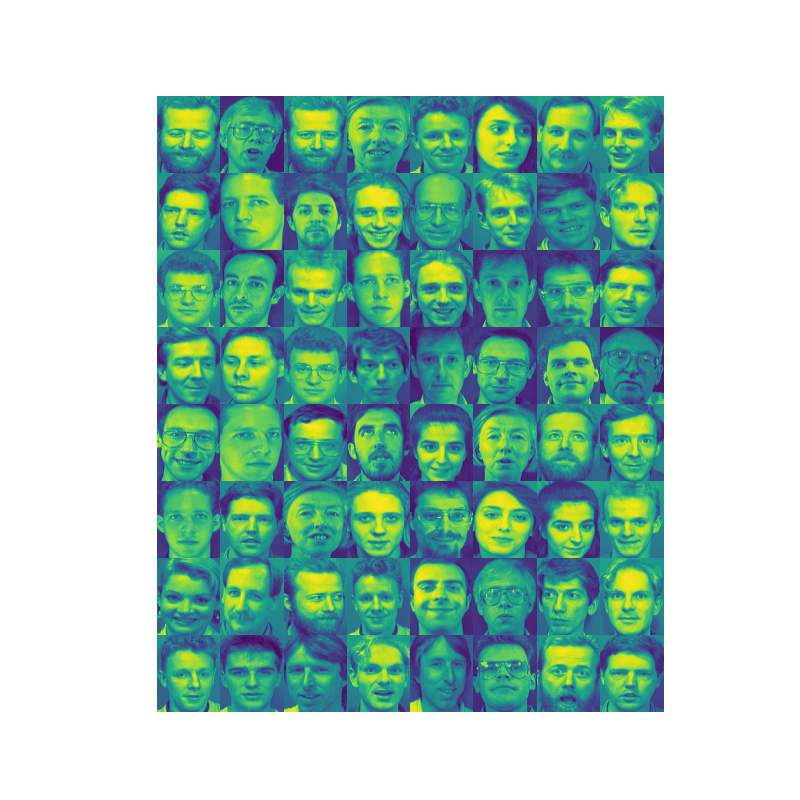

In [3]:
# Visualize some of the faces
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(8, 8), axes_pad=0)

for ax, im in zip(grid, images[:64]):
    ax.imshow(im)
    ax.axis('off')

<IPython.core.display.Javascript object>


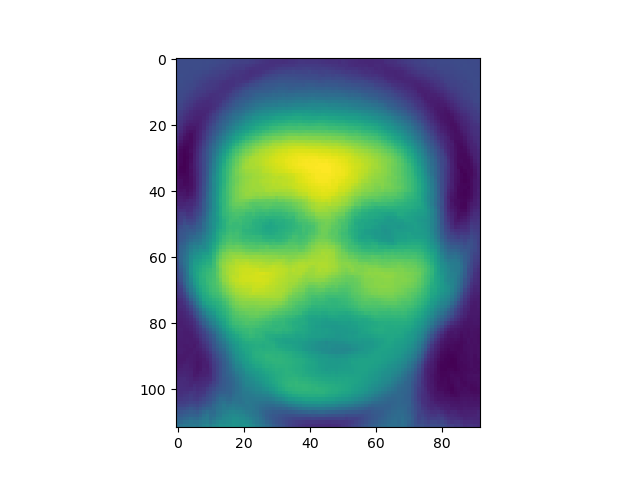

In [4]:
# Calculate the mean face
face_mean = images.mean(0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(face_mean)

# Performing Eigendecomposition

There are 400 images with resolution 92 x 112. To calculate a covariance matrix, you'll need to reshape the images so that each one is a 10304-dimensional vector. Now we can easily compute a covariance matrix, right?

## Computational Complexity of $X^T X$

The covariance matrix of a dataset with 10304 features will be $10304 \times 10304$. This will take a long time to compute. **Instead, we will compute the covariance matrix of the 400 samples. This yields a $400 \times 400$ matrix.**

**How do the eigenvectors of the $400 \times 400$ covariance matrix relate to the $10304 \times 10304$ matrix?**

Let $X \in \mathbb{R}^{10304 \times 400}$. Then $P = X^T X \in \mathbb{R}^{400 \times 400}$ and $C = X X^T \in \mathbb{R}^{10304 \times 10304}$. If $\mathbf{v}_i$ is an eigenvector of $P$ then $P\mathbf{v}_i = \lambda_i \mathbf{v}_i$, and

\begin{align*}
    X P \mathbf{v}_i &= \lambda_i X \mathbf{v}_i\\
    X X^T X \mathbf{v}_i &= \lambda_i X \mathbf{v}_i\\
    C X \mathbf{v}_i &= \lambda_i X \mathbf{v}_i
\end{align*}

If we let $\mathbf{u}_i = X \mathbf{v}_i$, then $\mathbf{u}_i$ and $\lambda_i$ are the 400 eigenvectors and eigenvalues of $C$.

For reconstruction purposes, normalize each $\mathbf{u}_i$.

In [6]:
num_images, height, width = images.shape

# Subtract the mean image from all images
images_sub = images - face_mean

# Vectorize the images to a 400 x 10304 matrix
X = images_sub.reshape(num_images, -1)

# Create the covariance matrix
X_cov = 1 / (num_images - 1) * (X @ X.T)

# Compute the eigendecomposition
D, V = np.linalg.eig(X_cov)
sort_idx = D.argsort()[::-1]
D = D[sort_idx]
V = V[:,sort_idx]

# Calculate U = V.T @ X -- would be written as X @ V but X has been transposed
eigenfaces = V.T @ X
eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=1)[:, np.newaxis]

# Calculate the weights
weights = X @ eigenfaces.T

<IPython.core.display.Javascript object>


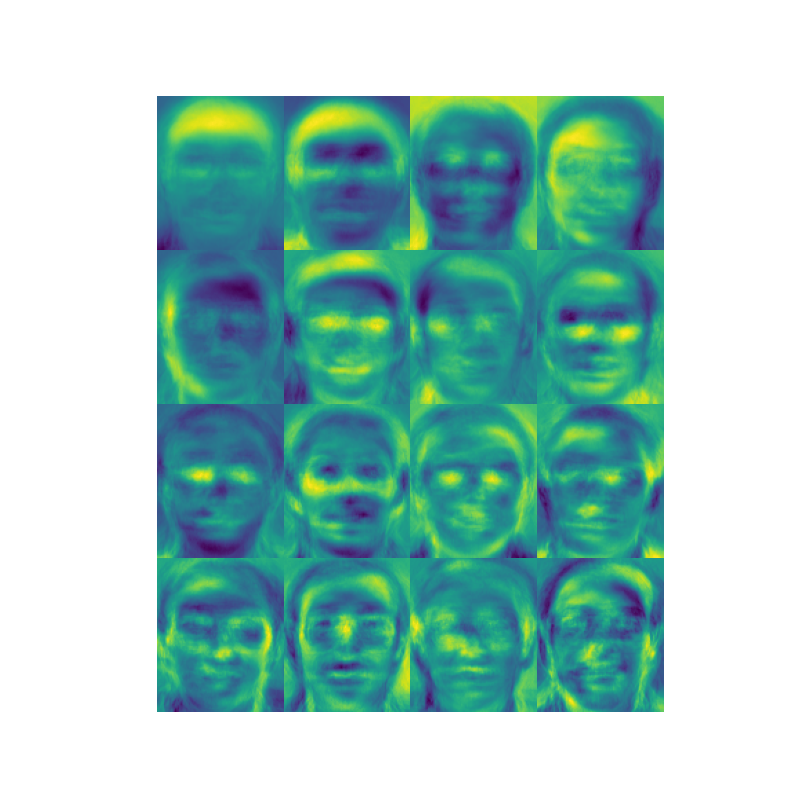

In [7]:
# Visualize some eigenfaces
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0)

for ax, im in zip(grid, eigenfaces[:16]):
    ax.imshow(im.reshape(height, width))
    ax.axis('off')

# Eigenfaces as a form of compression

We can reconstruct the original images from the eigenfaces.

In [8]:
def reconstruct(weights, eigenfaces, X_mean, img_size, img_idx, n_comps=400):
    """Reconstruct the image given by `img_idx` using eigenfaces."""
    h, w = img_size
    print(weights.shape, eigenfaces.shape, X_mean.shape)
    recovered_img = X_mean.copy() + (weights[img_idx, :n_comps] @ eigenfaces[:n_comps, :])
    return recovered_img.reshape(h, w)

(400, 400) (400, 10304) (10304,)


<IPython.core.display.Javascript object>


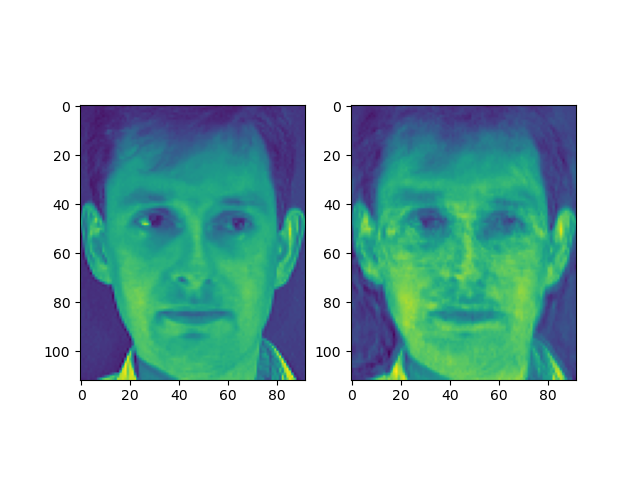

In [9]:
img_idx = 200
n_comps = 200

recovered_img = reconstruct(weights, eigenfaces, face_mean.reshape(-1), [height, width], img_idx, n_comps)

# Visualize original and reconstructed
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(images[img_idx])
ax2.imshow(recovered_img)